In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)

In [82]:
from lib.tqdm_streamer import TokenProgressStreamer
from lib.chain_of_thought import extract_chain_of_thought
from lib.soft_stop_thinking import get_soft_stop_thinking_fn
from lib.do_you_know_quote_prompt import build_prompt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json
import re
import torch
from nnsight import LanguageModel
import nnsight

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
MODEL_NAME = 'Qwen/Qwen3-32B'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = LanguageModel(MODEL_NAME, dtype=torch.bfloat16, device_map='cuda:0')
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=8192, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=8192, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (up_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (down_proj): Linear(in_features=25600, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_la

In [48]:
confidence_prompts = pd.read_csv('dataset/confidence_prompts.csv')
print(confidence_prompts['category'].value_counts().to_dict())
confidence_prompts

{'confident': 160, 'uncertain': 160}


,category,prompt
0,confident,I've found the right answer.
1,confident,I've identified the correct solution.
2,confident,I've located the information needed.
3,confident,I've figured this out completely.
4,confident,I've successfully found what was asked.
...,...,...
315,uncertain,This might not be credible.
316,uncertain,This could be undependable information.
317,uncertain,This might not be a sound response.
318,uncertain,This could be a shaky answer.


In [49]:
def get_layer_activations(prompt: str, pos: int = -1) -> torch.Tensor:
    messages = [{"role": "assistant", "content": f"<think>{prompt}"}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False, continue_final_message=True
    )

    layer_activations = []

    with torch.no_grad():
        with model.trace(formatted_prompt):
            for layer in model.model.layers:
                activation = layer.output[0, pos, :].save()
                layer_activations.append(activation.cpu())

    result = torch.stack(layer_activations).cpu()

    return result

# Evaluate confidence vector

In [50]:
activations = torch.stack(
    [get_layer_activations(prompt) for prompt in tqdm(confidence_prompts.prompt.values)],
)

100%|██████████| 320/320 [00:29<00:00, 10.91it/s]


In [51]:
confident_indices = confidence_prompts[confidence_prompts.category == 'confident'].index.tolist()
uncertain_indices = confidence_prompts[confidence_prompts.category == 'uncertain'].index.tolist()

In [52]:
confidence_by_layer = activations[confident_indices].mean(axis=0) - activations[uncertain_indices].mean(axis=0)  # type: ignore
normalized_confidence = confidence_by_layer / torch.norm(confidence_by_layer, dim=-1, keepdim=True)

In [53]:
projections = (activations * normalized_confidence.unsqueeze(0)).sum(dim=-1)

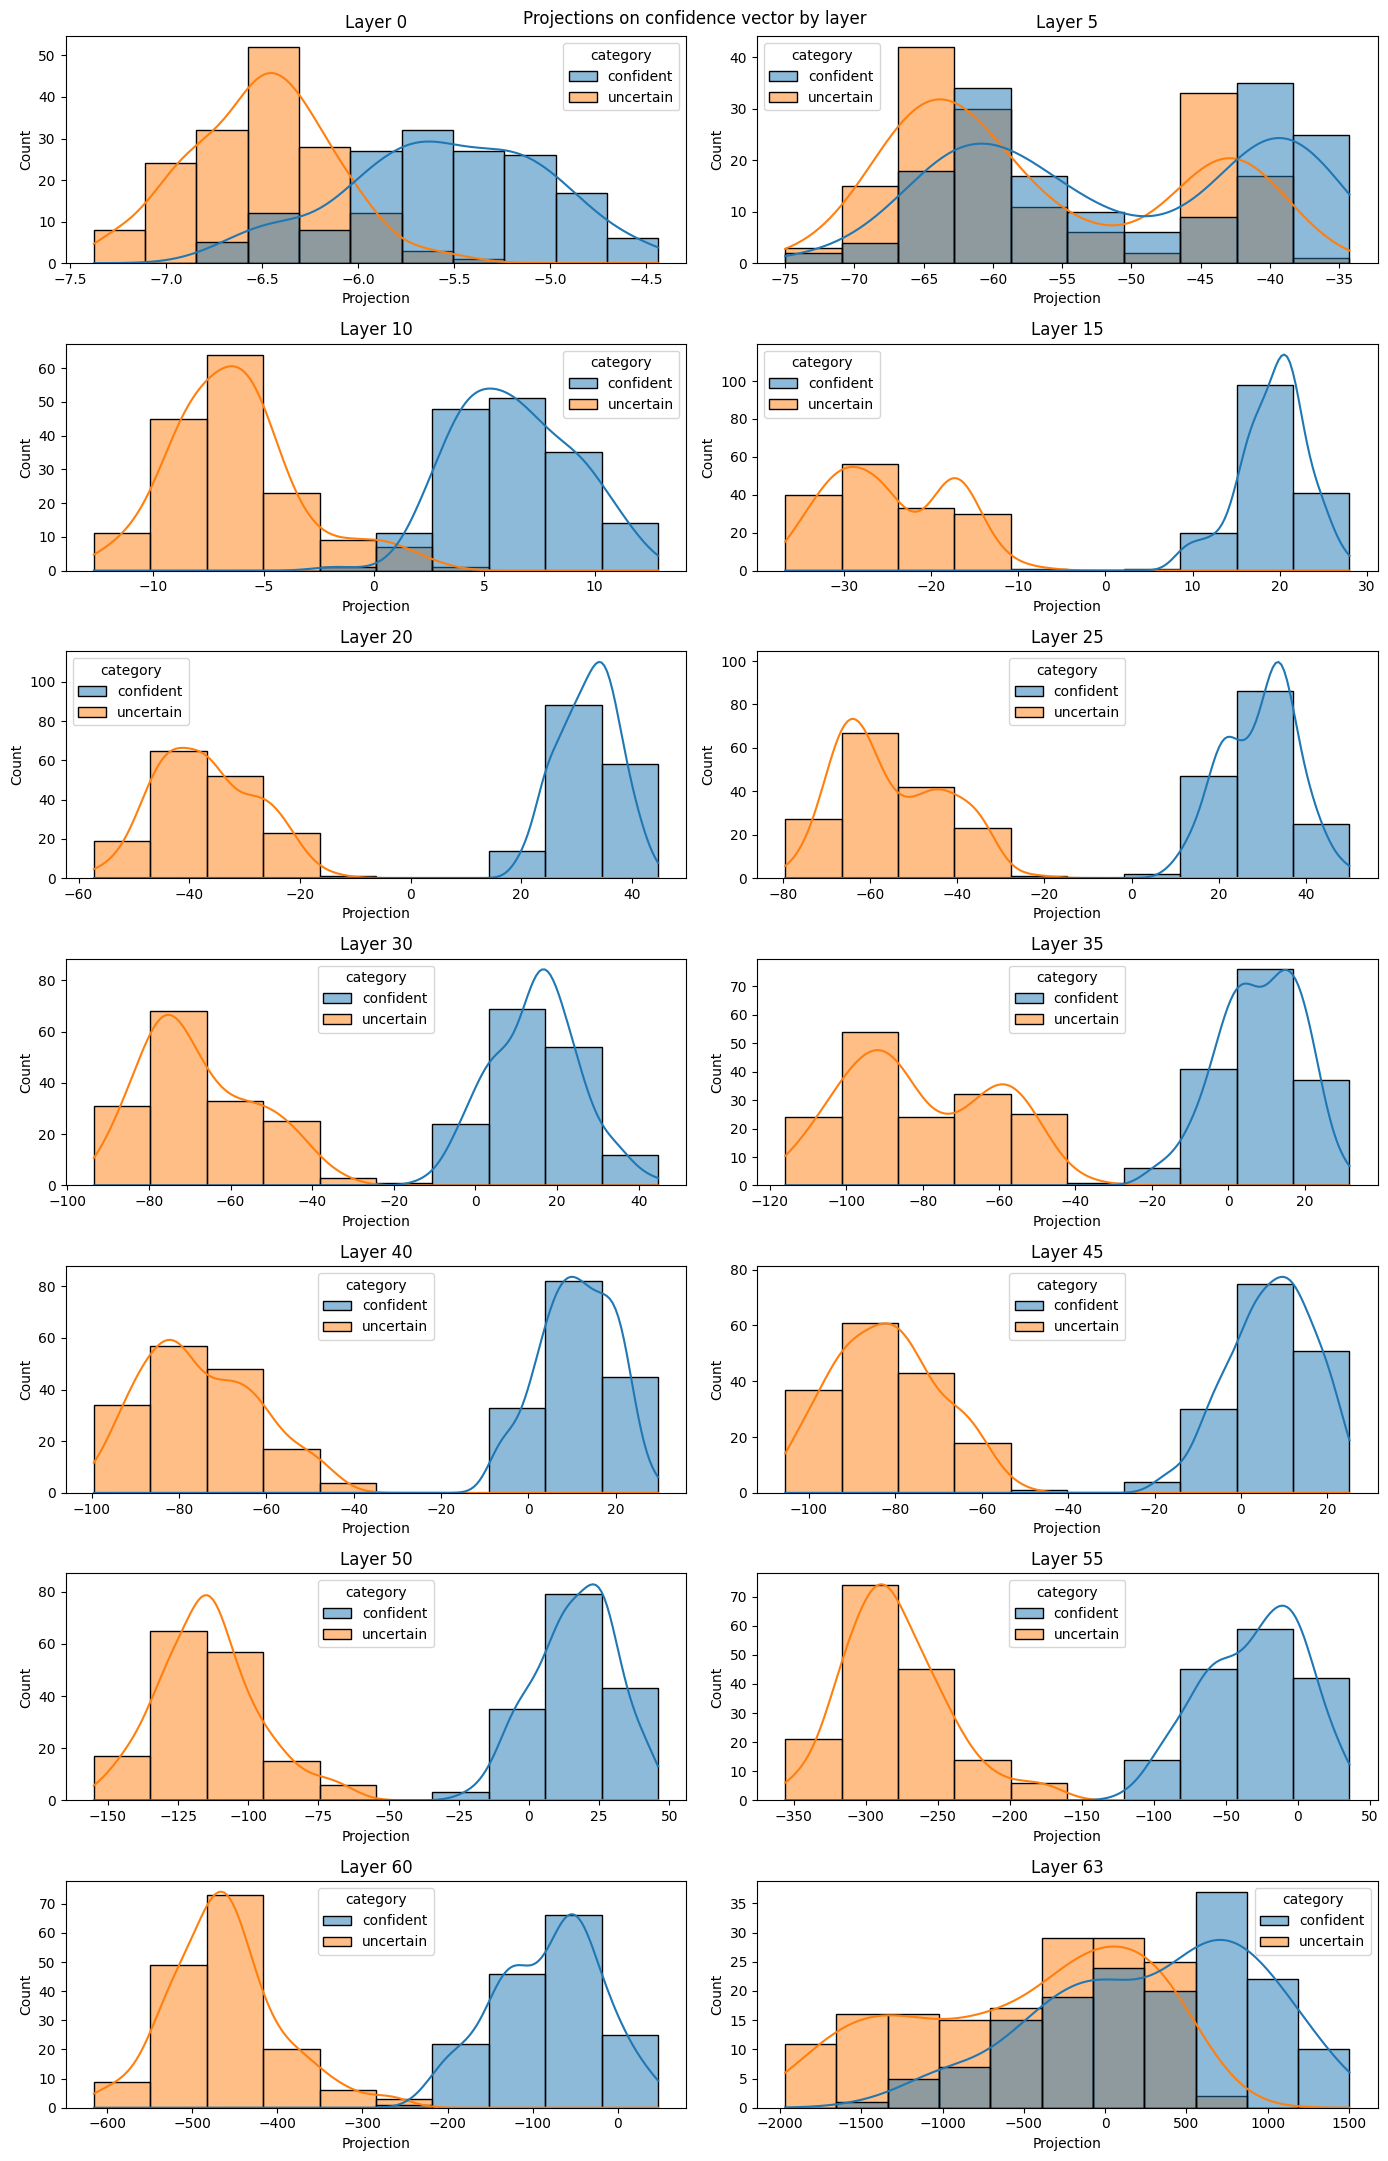

In [ ]:
layers = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 63]
fig, axes = plt.subplots(7, 2, figsize=(14, 22))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    data = pd.concat([confidence_prompts, pd.DataFrame({'projection': projections[:, layer].tolist()})], axis=1)
    sns.histplot(data, x='projection', hue='category', kde=True, ax=axes[idx])
    axes[idx].set_title(f'Layer {layer}')
    axes[idx].set_xlabel('Projection')
    axes[idx].set_ylabel('Count')

plt.suptitle('Projections on confidence vector by layer')
plt.tight_layout()
plt.show()

In [54]:
separability_by_layer = (projections[confident_indices].std(dim=0) + projections[uncertain_indices].std(dim=0)) / (
    (projections[confident_indices].mean(dim=0) - projections[uncertain_indices].mean(dim=0))
).abs()

most_separable_layer = separability_by_layer.argmin().item()

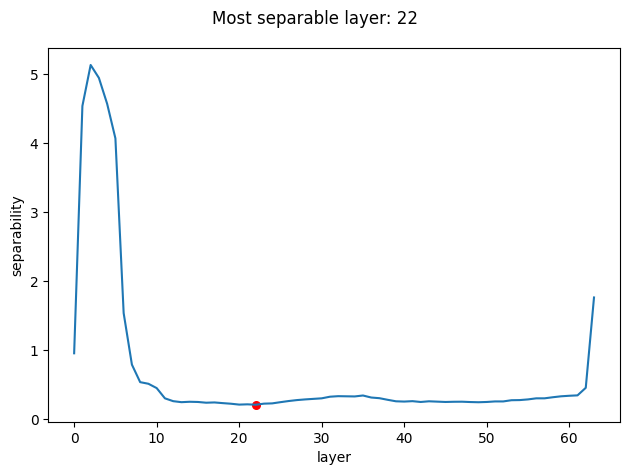

In [56]:
data = pd.Series(separability_by_layer.tolist()).to_frame(name='separability').reset_index(names=['layer'])
sns.lineplot(data, x='layer', y='separability')
plt.scatter(x=[most_separable_layer], y=[separability_by_layer[most_separable_layer].item()], color='red', s=30)
plt.suptitle(f'Most separable layer: {most_separable_layer}')
plt.tight_layout()
plt.show()

In [59]:
confidence_vector = normalized_confidence[most_separable_layer]
confident_projection = projections[confident_indices][most_separable_layer].mean().item()
uncertain_projection = projections[uncertain_indices][most_separable_layer].mean().item()

with open('dataset/confidence_vector.json', 'w') as out:
    data = {
        'confidence_vector': confidence_vector.tolist(),
        'most_separable_layer': most_separable_layer,
        'confident_projection': confident_projection,
        'uncertain_projection': uncertain_projection,
    }
    json.dump(data, out)

In [30]:
with open('dataset/confidence_vector.json', 'r') as inp:
    confidence_vector = torch.tensor(json.load(inp), dtype=torch.bfloat16)

# Plot confidence of generated tokens

In [152]:
def generate_and_project(
    prompt: str,
    direction: torch.Tensor,
    enable_thinking: bool = True,
    max_new_tokens: int = 32768,
    thinking_budget: int = 32768,
    layer_no: int = -1,
    random_state: int = 42,
    temperature: float = 0.6,
    top_p: float = 0.95,
    top_k: int = 20,
    **generate_kwargs,
):
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
    )

    input_token_length = len(tokenizer.encode(formatted_prompt))
    prefix_allowed_tokens_fn = (
        get_soft_stop_thinking_fn(
            tokenizer=tokenizer,
            thinking_budget=thinking_budget,
            input_length=input_token_length,
            model_vocab_size=model.config.vocab_size,
        )
        if enable_thinking
        else None
    )

    direction = direction.to(device)
    projections = []

    with torch.no_grad():
        torch.manual_seed(random_state)
        with model.generate(
            formatted_prompt,
            max_new_tokens=max_new_tokens,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            **generate_kwargs,
        ) as tracer:
            with tracer.all():
                layer = model.model.layers[layer_no]
                layer_output = layer.output[0]

                projection = (layer_output @ direction).save()
                projections.append(projection)

        torch.manual_seed(random_state)
        with model.generate(
            formatted_prompt,
            max_new_tokens=max_new_tokens,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            **generate_kwargs,
        ):
            output = model.generator.output[0].save()

    projections = torch.cat(projections)
    generated_ids = output.tolist()
    if (eos := generated_ids.pop()) != tokenizer.added_special_tokens_encoder['<|im_end|>']:
        print('Expected <|im_end|> token, but got', eos)
        generated_ids.append(eos)

    chain_of_thought, answer, thinking_duration = extract_chain_of_thought(
        generated_ids[input_token_length:],
        tokenizer=tokenizer,
    )

    return {
        'answer': answer,
        'chain_of_thought': chain_of_thought,
        'projections': projections,
        'tokens': generated_ids,
        'input_token_length': input_token_length,
        'thinking_duration': thinking_duration,
        'projections': projections,
    }

# Debug

In [134]:
demo_quote = 'My entire life savings! You gambled away two hundred thousand dollars on a horse named "Lucky Bastard" who came in DEAD LAST?!'
demo_prompt = build_prompt(demo_quote)

In [139]:
result = [
    generate_and_project(
        demo_prompt,
        confidence_vector,
        max_new_tokens=1024,
        thinking_budget=1024 - 128,
        random_state=i,
    )
    for i in tqdm(range(42, 52))
]

  0%|          | 0/10 [00:00<?, ?it/s]/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.layers.63.output.i917` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
 10%|█         | 1/10 [02:00<18:05, 120.58s/it]/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.layers.63.output.i446` was not provided. If this was in an Iterator at iteration None this iteration did not happen. If you were using `.iter[:]`, this is likely not an error.
  warnings.warn(msg)
 20%|██        | 2/10 [02:58<11:11, 83.94s/it] /workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/nnsight/intervention/interleaver.py:402: UserWarning: Execution complete but `model.model.layers.63

In [140]:
for index, item in enumerate(result):
    print(f'{index}:', item['answer'])

0: Yes, the phrase is from the movie *The Hangover* (2009).
1: Yes, the phrase is from *The Hangover* (2009).
2: Yes, the phrase is from *The Hangover Part II* (2011). In the movie, Alan (Zach Galifianakis) bets his life savings on a horse named "Lucky Bastard," which finishes last in the race, leading to the exasperated outburst.
3: Yes, the phrase is from *Brooklyn Nine-Nine*. It appears in Season 3, Episode 4 ("The Bet"), where Boyle (played by Joe Lo Truglio) expresses outrage after Jake Peralta (Andy Samberg) gambles his money on a horse named "Lucky Bastard," which finishes last.
4: Yes, the phrase is from the movie *The Hangover Part II* (2011). In the film, a character named Alan (played by Zach Galifianakis) becomes enraged upon discovering that his life savings were lost on a bet involving a horse named "Lucky Bastard," which finished dead last in the race.
5: Yes, the phrase is from *The Hangover Part II* (2011), where Alan (played by Zach Galifianakis) delivers this line af

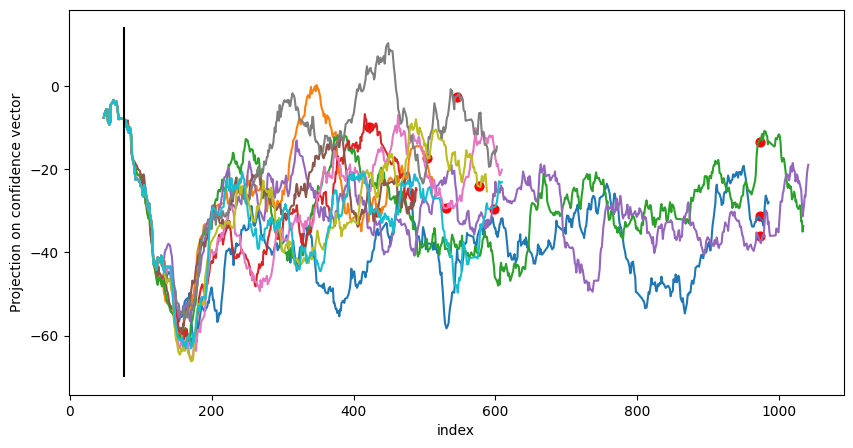

In [202]:
plt.figure(figsize=(10, 5))

for item in result:
    data = pd.DataFrame({'projection': item['projections'].tolist(), 'token': item['tokens']}).reset_index(
        names=['index']
    )
    data['symbol'] = data.token.apply(tokenizer.decode)
    data['is_alphabetical'] = data.symbol.str.contains('[a-zA-Z]') & ~data.symbol.str.startswith('<')
    data['projection_smoothened'] = data[data.is_alphabetical].projection.rolling(40).mean().reindex(data.index)

    # sns.lineplot(data.iloc[1:], x='layer', y='projection')
    sns.lineplot(data.iloc[1:], x='index', y='projection_smoothened')
    prompt_and_thinking = item['input_token_length'] + item['thinking_duration']
    smoothened_projection_at_boundary = data.projection_smoothened.ffill().iloc[prompt_and_thinking]
    plt.scatter(
        [prompt_and_thinking - 0.5],
        [smoothened_projection_at_boundary],
        color='red',
        s=40,
    )

plt.vlines([item['input_token_length'] - 0.5], *plt.ylim(), color='k')
plt.ylabel('Projection on confidence vector')
plt.show()